In [1]:
%load_ext autoreload
%autoreload 2

train_path = "Dataset/Train"
test_path = "Dataset/Test"
val_path = "Dataset/Val" 

In [2]:
import os
import torch
import torch.nn.functional as F

from models.hybrid import HybridGNet
from models.hybridDual import HybridDual
from models.hybridDualSkip import HybridDualSkip
from models.UNet import UNet

import numpy as np
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse

print('Dependencies Loaded')

Dependencies Loaded


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

A = np.load('adjacencyMatrix.npy')
A = sp.csc_matrix(A).tocoo()

I = np.eye(166)
I = sp.csc_matrix(I).tocoo()

D = [I.copy(), I.copy(), I.copy(), I.copy()]
U = [I.copy(), I.copy(), I.copy(), I.copy()]
A = [A.copy(), A.copy(), A.copy(), A.copy()]

A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A, D, U))

num_nodes = [166, 166, 166, 166]
num_features = 2

cuda:0


In [4]:
config = {}

config['n_layers'] = 4
config['num_conv_filters'] = [16, 16, 16, 16, 16]
config['polygon_order'] = [6, 6, 6, 6, 6]
config['kld_weight'] = 1e-5
config['z'] = 64

dual = HybridDual(config, num_features, D_t, U_t, A_t, num_nodes).to(device)
dual.load_state_dict(torch.load("weights/dual.pt"))
dual.eval()

config = {}

config['n_layers'] = 4
config['num_conv_filters'] = [16, 16, 16, 16, 16]
config['polygon_order'] = [6, 6, 6, 6, 6]
config['kld_weight'] = 1e-5
config['z'] = 64

dualSkip = HybridDualSkip(config, num_features, D_t, U_t, A_t, num_nodes).to(device)
dualSkip.load_state_dict(torch.load("weights/dualSkip.pt"))
dualSkip.eval()

unet = UNet().to(device)
unet.load_state_dict(torch.load("weights/unet.pt"))
unet.eval()

print('')

In [5]:
from dataLoader import LandmarksDataset, Rescale, ToTensor
from torchvision import transforms
import os

img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'landmarks')
test_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(512),
                                             ToTensor()])
                                 )

torch.manual_seed(420)

sample = test_dataset[0]
image, target, seg = sample['image'].to(device), sample['landmarks'].to(device), sample['seg']

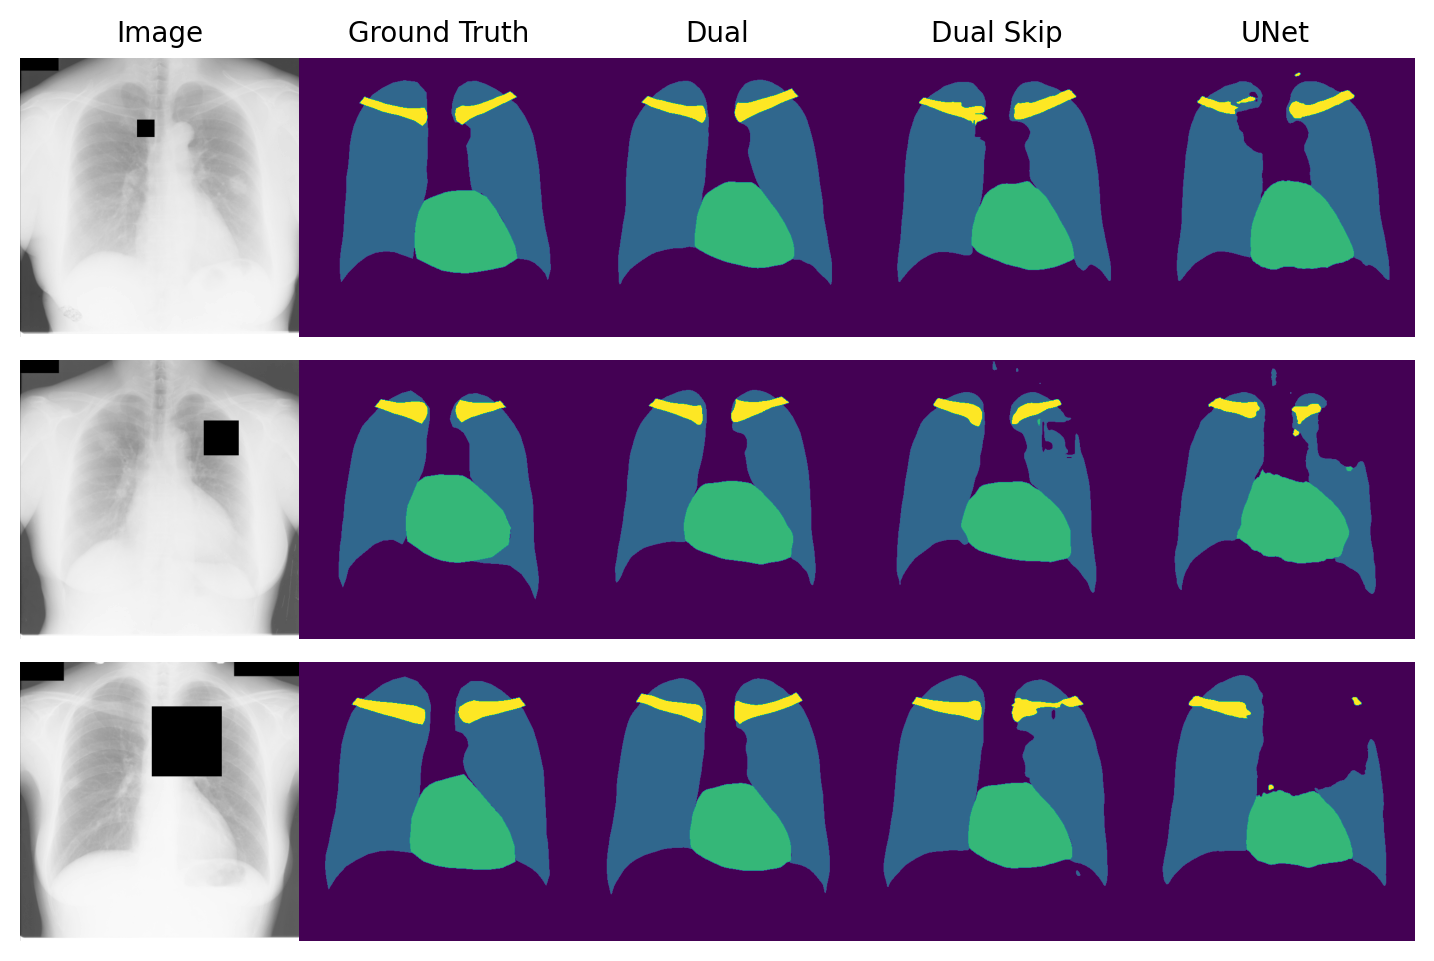

In [6]:
import matplotlib.pyplot as plt

def genBlock(image, center = (256,256), size = 32):
    a = center[0] - size // 2
    b = center[0] + size // 2
    c = center[1] - size // 2
    d = center[1] + size // 2
    image[0, a:b, c:d] = 0
    
    return image

sample = test_dataset[5]
image, target, seg = sample['image'], sample['landmarks'].to(device), sample['seg']

size = 96

plt.figure(figsize = (9,6), dpi = 200)

for j in range(0, 3):
    sample = test_dataset[j]
    image, target, seg = sample['image'], sample['landmarks'].to(device), sample['seg']

    size = 32 * (2 ** (j))
    
    posx = np.random.randint(128, 512-128)
    posy = np.random.randint(128, 512-128)
    
    imageb = image.numpy().copy()
    broken = torch.from_numpy(genBlock(imageb, center = (posx,posy), size = size)).to(device)

    plt.subplot(3,5,1 + j*5)
    plt.imshow(broken[0,:,:].cpu(), cmap = 'gray')
    if j==0:
        plt.title('Image', fontsize=10)
    plt.axis('off')

    plt.subplot(3,5,2 + j*5)
    plt.imshow(seg[0,:,:])
    
    if j==0:
        plt.title('Ground Truth', fontsize=10)
    plt.axis('off')

    with torch.no_grad():
        _, seg_pred = dual(torch.unsqueeze(broken,0))

        seg_pred = seg_pred[0,:,:,:].cpu().numpy().transpose((1,2,0))

        seg_pred = np.argmax(seg_pred, 2)

    plt.subplot(3,5,3 + j*5)
    plt.imshow(seg_pred)
    
    if j==0:
        plt.title('Dual', fontsize=10)
    plt.axis('off')

    with torch.no_grad():
        _, seg_pred = dualSkip(torch.unsqueeze(broken,0))

        seg_pred = seg_pred[0,:,:,:].cpu().numpy().transpose((1,2,0))

        seg_pred = np.argmax(seg_pred, 2)
        
    plt.subplot(3,5,4 + j*5)
    plt.imshow(seg_pred)
    
    if j==0:
        plt.title('Dual Skip', fontsize=10)
    plt.axis('off')

    with torch.no_grad():
        seg_pred = unet(torch.unsqueeze(broken,0))

        seg_pred = seg_pred[0,:,:,:].cpu().numpy().transpose((1,2,0))

        seg_pred = np.argmax(seg_pred, 2)

    plt.subplot(3,5,5 + j*5)
    plt.imshow(seg_pred)
    
    if j==0:
        plt.title('UNet', fontsize=10)
    plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [10]:
from medpy.metric import dc, hd, assd, jc
from utils.fun import reverseVector, drawBinary

model_list = [unet, dual, dualSkip]
model_names = ['UNet','HybridGNet Dual','HybridGNet Dual Skip']

def evalImageMetricsUNetFast(output, target):
    ptest = output == 1
    pgt = target == 1
    
    dcp = dc(ptest, pgt)
    hdp = hd(ptest, pgt, voxelspacing = 0.7)
    
    ptest = output == 2
    pgt  = target == 2
    
    dcc = dc(ptest, pgt)
    hdc = hd(ptest, pgt, voxelspacing = 0.7)
    
    ptest = output == 3
    pgt  = target == 3
    
    dccla = dc(ptest, pgt)
    hdcla = hd(ptest, pgt, voxelspacing = 0.7)
    
    return (dcp + dcc + dccla)/3, (hdp + hdc + hdcla)/3

In [11]:
import pandas as pd

results2 = pd.DataFrame()

sizes = [0, 16, 32, 48, 64, 80, 96, 112, 128]

for size in sizes:
    print('Size', size)
    
    for k in range(0, 7):
        posx = np.random.randint(128, 512-128)
        posy = np.random.randint(128, 512-128)
                
        for i in range(0, len(test_dataset.images)):
            print('image %s' %i, end='\r', flush = True)
            with torch.no_grad():
                sample = test_dataset[i]

                data, target = sample['image'], sample['seg']

                if size != 0:
                    broken = genBlock(data, center = (posx,posy), size = size)
                    data = torch.unsqueeze(broken, 0).to(device)
                else:
                    data = torch.unsqueeze(data, 0).to(device)

                target = target.numpy()[0,:,:]

                for j in range(0, len(model_list)):
                    output = model_list[j](data)
                    if len(output) > 1:
                        output = output[1]

                    output = output[0,:,:,:].cpu().numpy().transpose((1,2,0))
                    seg = np.argmax(output, 2)

                    dice_, hd_ = evalImageMetricsUNetFast(seg, target)
                    aux = pd.DataFrame([[i, model_names[j], size, k, dice_, hd_]], columns=['i', 'Model', 'Oclusion', 'K', 'Dice', 'Hausdorff'])
                    results2 = results2.append(aux, ignore_index = True)
                    
        print('')
        if size == 0:
            break

Size 0
image 50
Size 16
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 32
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 48
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 64
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 80
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 96
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 112
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 128
image 50
image 50
image 50
image 50
image 50
image 50
image 50


In [13]:
dice_plot_means = []
dice_plot_stds = []

for model in model_names:
    model_means = []
    model_stds = []

    for size in sizes:
        means = []
        stds = []
        for k in range(0, 7):
            mean = results2['Dice'][(results2['Model']==model) & (results2['K'] == k) & (results2['Oclusion'] == size)].mean()
            std = results2['Dice'][(results2['Model']==model) & (results2['K'] == k) & (results2['Oclusion'] == size)].std()
            means.append(mean)
            stds.append(std)
            if size == 0:
                break
                
        real_mean = np.mean(means)
        real_std = np.mean(stds)

        model_means.append(real_mean)
        model_stds.append(real_std)
    
    dice_plot_means.append(model_means)
    dice_plot_stds.append(model_stds)
    
hd_plot_means = []
hd_plot_stds = []

for model in model_names:
    model_means = []
    model_stds = []

    for size in sizes:
        means = []
        stds = []
        for k in range(0, 7):
            mean = results2['Hausdorff'][(results2['Model']==model) & (results2['K'] == k) & (results2['Oclusion'] == size)].mean()
            std = results2['Hausdorff'][(results2['Model']==model) & (results2['K'] == k) & (results2['Oclusion'] == size)].std()
            means.append(mean)
            stds.append(std)
            if size == 0:
                break
                
        real_mean = np.mean(means)
        real_std = np.mean(stds)

        model_means.append(real_mean)
        model_stds.append(real_std)
    
    hd_plot_means.append(model_means)
    hd_plot_stds.append(model_stds)

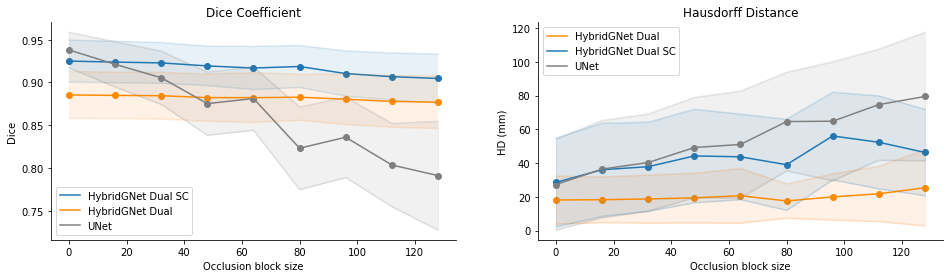

In [15]:
# Define variables to plot
x = np.array(sizes)

pal = sns.color_palette()
pal.as_hex()

blue = list(pal[0]) + [1]
blue = np.array(blue) 

plt.subplots(figsize=(16,4))
ax = plt.subplot(1,2,1)

y_mean = np.array(dice_plot_means[2])
error =np.array(dice_plot_stds[2])
lower = y_mean - error
upper = y_mean + error

ax.plot(x, y_mean, label='HybridGNet Dual SC', color = blue)
ax.scatter(x, y_mean, color = blue)
ax.plot(x, lower, color='tab:blue', alpha=0.15)
ax.plot(x, upper, color='tab:blue', alpha=0.15)
ax.fill_between(x, lower, upper, alpha=0.1)

y_mean = np.array(dice_plot_means[1])
error =np.array(dice_plot_stds[1])
lower = y_mean - error
upper = y_mean + error

ax.plot(x, y_mean, label='HybridGNet Dual', color = 'darkorange')
ax.scatter(x, y_mean, color = 'darkorange')
ax.plot(x, lower, color='tab:orange', alpha=0.15)
ax.plot(x, upper, color='tab:orange', alpha=0.15)
ax.fill_between(x, lower, upper, alpha=0.1)

y_mean = np.array(dice_plot_means[0])
error = np.array(dice_plot_stds[0])
lower = y_mean - error
upper = y_mean + error

ax.plot(x, y_mean, label='UNet', color = 'gray')
ax.scatter(x, y_mean, color = 'gray')
ax.plot(x, lower, color='tab:gray', alpha=0.15)
ax.plot(x, upper, color='tab:gray', alpha=0.15)
ax.fill_between(x, lower, upper, alpha=0.1, color='tab:gray')

ax.set_xlabel('Occlusion block size')
ax.set_ylabel('Dice')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Dice Coefficient')

plt.legend()

ax = plt.subplot(1,2,2)

y_mean = np.array(hd_plot_means[1])
error =np.array(hd_plot_stds[1])
lower = y_mean - error
upper = y_mean + error

ax.plot(x, y_mean, label='HybridGNet Dual', color = 'darkorange')
ax.scatter(x, y_mean, color = 'darkorange')
ax.plot(x, lower, color='tab:orange', alpha=0.15)
ax.plot(x, upper, color='tab:orange', alpha=0.15)
ax.fill_between(x, lower, upper, alpha=0.1, color='tab:orange')

y_mean = np.array(hd_plot_means[2])
error =np.array(hd_plot_stds[2])
lower = y_mean - error
upper = y_mean + error

ax.plot(x, y_mean, label='HybridGNet Dual SC', color = blue)
ax.scatter(x, y_mean, color = blue)
ax.plot(x, lower, color='tab:blue', alpha=0.15)
ax.plot(x, upper, color='tab:blue', alpha=0.15)
ax.fill_between(x, lower, upper, alpha=0.1, color='tab:blue')

y_mean = np.array(hd_plot_means[0])
error = np.array(hd_plot_stds[0])
lower = y_mean - error
upper = y_mean + error

ax.plot(x, y_mean, label='UNet', color = 'gray')
ax.scatter(x, y_mean, color = 'gray')
ax.plot(x, lower, color='tab:gray', alpha=0.15)
ax.plot(x, upper, color='tab:gray', alpha=0.15)
ax.fill_between(x, lower, upper, alpha=0.1, color='tab:gray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Occlusion block size')
ax.set_ylabel('HD (mm)')
ax.set_title('Hausdorff Distance')

plt.legend()
plt.show()